Importing required libraries to predict acceleration using random forest, calculate RMSE (RootMeanSquaredError), and create plots to compare predicted and actual acceleration

In [661]:
import pandas as pd
import numpy as np
import FileProcessing
import ModelClass
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns



In [662]:
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
from tensorflow.keras import layers


In [663]:
class ModelClass():

    '''
    #        x = layers.Conv1D(16,6,activation="sigmoid", name='Block1_Conv1')(input)
    '''
    
    def define_neural_network(self, input_df):

        #input = keras.Input(shape=(18,))
        input_df = tensorflow.expand_dims(input_df, axis=-1)

        input = keras.Input(shape=(input_df.shape[1],1))

        x = layers.Conv1D(filters=16,kernel_size=(2),padding='same',activation="sigmoid", name='Block1_Conv1')(input)
        x = layers.Conv1D(filters=16,kernel_size=(2),padding='same',activation="sigmoid", name='Block1_Conv2')(x)
        x = layers.MaxPooling1D(pool_size=2,strides=2,name='Block1_Pool')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv1D(filters=32, kernel_size=(2),padding='same',activation="tanh", name='Block2_Conv1')(x)
        x = layers.Conv1D(filters=32, kernel_size=(2),padding='same',activation="tanh", name='Block2_Conv2')(x)
        x = layers.MaxPool1D(pool_size=2,strides=2,name='Block2_Pool')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        #prework for fully connected layer. 
        x = layers.Flatten()(x)
        # Fully connected layers
        x = layers.Dense(128, activation='tanh')(x)
        x = layers.Dense(64, activation='sigmoid')(x)
        x = layers.Dense(16, activation='tanh')(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)

        model = keras.Model(inputs=input, outputs=outputs)
        model.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])
        model.summary()

        return model

    def fit_neural_network(self, model, X_train, y_train,X_val,y_val):
        history=model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_val,y_val))
        #convertingt the accuracy of the model to a graph. 
        history_dict = history.history # the dictionary that has the information on loss and accuracy per epoch

        loss_values = history_dict['loss']   # training loss
        val_loss_values = history_dict['val_loss'] # validation loss

        epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

        # code to plot the results
        plt.plot(epochs, loss_values, 'b', label="Training Loss")
        plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.xticks(epochs)
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        # As above, but this time we want to visualize the training and validation accuracy
        acc_values = history_dict['accuracy']
        val_acc_values = history_dict['val_accuracy']

        plt.plot(epochs, acc_values, 'b', label="Training Accuracy")
        plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.xticks(epochs)
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        return model

    def create_prediction_pair(self, df, n):
        '''
        create the prediction pair by shifting the actual data up by the mentioned number(0.1*n seconds) to create the timeseries info
        '''
        df=self.tranformations_for_models(df)
        df["nextframeAcc"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Acc"].shift(-1*n)
        df["nextframesvel"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Vel"].shift(-1*n)
        df["nextframeposition"] = df.groupby(
            ["L-F_Pair"], as_index=False)["Local_Y"].shift(-1*n)
        df['nextframeposition'] = df['nextframeposition'].fillna(0)
        df['nextframesvel'] = df['nextframesvel'].fillna(0)
        df['nextframeAcc'] = df['nextframeAcc'].fillna(0)

        return df

    def tranformations_for_models(self, df):
        
        '''
        Read the input file into a dataframe.
        Input: File name for the file present in Data folder.
        Output: Dataframe name.
        '''
#        df["Vehicle_combination_cat"] = df["Vehicle_combination"].astype("category").cat.codes
        df["Location_cat"]=df["Location"].astype("category").cat.codes
                                          
        drop_columns_list=['Vehicle_ID','Frame_ID','Global_Time','Local_X','Global_X','Global_Y','v_length','Lane_ID','Preceding','Space_Headway','Time_Headway','v_Class_Name','lane_changes','preceding_car_lane_changes','Prec_Vehicle_ID','Vehicle_combination','Preceding_Vehicle_Class','Relative_Time']
        df["Front_To_Rear_Time_Headway"] = df["Front_To_Rear_Time_Headway"].replace(np.inf, 999)
        df[df.select_dtypes(np.float64).columns]=df.select_dtypes(np.float64).astype(np.float32)
        df=df.drop(drop_columns_list,axis=1,errors='ignore')
        return df

    def test_train_pairs(self, df, split, seed=0):
        '''
        Read the input file into a dataframe.
        Input: File name for the file present in Data folder.
        Output: Dataframe name.
        '''
        
        if seed >0:
            random.seed(seed)
        #df = df.applymap(lambda x: float(round(x, 4))if isinstance(x, (int, float)) else x)
        total_pairs = df["L-F_Pair"].unique()
        total_pairs = total_pairs.tolist()
        test_split_cnt = round(len(total_pairs)*split)
        test_split_pairs = random.sample(total_pairs, test_split_cnt)
        train_df = df[df['L-F_Pair'].isin(test_split_pairs)]
        test_df = df[~df['L-F_Pair'].isin(test_split_pairs)]

        validation_split_cnt = round(test_split_cnt*0.2)
        validation_split_pairs = random.sample(test_split_pairs, validation_split_cnt)
        val_df = df[df['L-F_Pair'].isin(validation_split_pairs)]
        train_df = df[~df['L-F_Pair'].isin(validation_split_pairs)]


        return train_df, val_df,test_df

    def prediction_test_pairs(self, df, pair_from, pair_to):
        unique_pairs_values = df['L-F_Pair'].unique()
        unique_pairs_list = unique_pairs_values.tolist()
        unique_pairs_df = unique_pairs_list[pair_from:pair_to]
        return unique_pairs_df

    def feature_selection(self, train_df, val_df,test_df):
        features=['Rear_to_Front_Space_Headway', 'preceding_v_Class',"v_Class",
                            'Velocity Difference_Following-Preceding', 'v_Vel','Location_cat']
        X_train = train_df[features]
        X_val = val_df[features]
        X_test = test_df[features]

        
        y_train = train_df['nextframeAcc']
        y_val = val_df['nextframeAcc']
        y_test = test_df['nextframeAcc']

        #scaler = StandardScaler().fit(X_train)
        #X_train = scaler.transform(X_train)
        #X_test = scaler.transform(X_test)

        return X_train, y_train, X_val,y_val, X_test, y_test

    

Loading the cleaned ngsim data using pandas

In [664]:
fileProcessing=FileProcessing.FileProcessing()

In [665]:
#model_obj=ModelClass.ModelClass()
model_obj=ModelClass()

In [666]:
file_name='Cleaned_NGSIM_Data'
ngsim=fileProcessing.read_input(file_name)

original File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


,preceding_vehicle_length,preceding_Vehicle_Velocity,preceding_Vehicle_Acceleration,preceding_car_lane_changes,preceding_Local_Y,preceding_v_Class


Adding new columns nextframe acceleration, velocity, and position which will be our target features.

In [668]:
ngsim=model_obj.create_prediction_pair(ngsim,1)

In [669]:
#ngsim

Spliting data into 70% training and 30% testing

In [670]:
train_df, val_df,test_df=model_obj.test_train_pairs(ngsim,0.9)

In [671]:
#print(train_df.isnull().sum())
#print(val_df.isnull().sum())

In [672]:
#train_df.dtypes

In [673]:
#print(test_df.isnull().sum())

In [674]:
#test_df

In [675]:
#train_df.dtypes

In [676]:
#print(np.isnan(train_df.any())) #and gets False)
#print(np.isfinite(train_df.all())) #and gets True)

In [677]:
#train_df = np.nan_to_num(train_df)

In [678]:
#train_df

In [679]:
#train_df = train_df.applymap(lambda x: float(round(x, 2)) if isinstance(x, (int, float)) else x)
#train_df

In [680]:
#from numpy import inf
#train_df[train_df == inf] = np.finfo(np.float32).max

In [681]:
X_train,y_train,X_val,y_val,X_test,y_test= model_obj.feature_selection(train_df,val_df,test_df)

In [682]:
model=model_obj.define_neural_network(X_train)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 6, 1)]            0         
_________________________________________________________________
Block1_Conv1 (Conv1D)        (None, 6, 16)             48        
_________________________________________________________________
Block1_Conv2 (Conv1D)        (None, 6, 16)             528       
_________________________________________________________________
Block1_Pool (MaxPooling1D)   (None, 3, 16)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 16)             64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 16)             0         
_________________________________________________________________
Block2_Conv1 (Conv1D)        (None, 3, 32)           

Epoch 1/10
22339/22339 [==============================] - 43s 2ms/step - loss: 2.1115 - accuracy: 0.2520 - val_loss: 2.2224 - val_accuracy: 0.2129
Epoch 2/10
22339/22339 [==============================] - 42s 2ms/step - loss: 2.1072 - accuracy: 0.2528 - val_loss: 2.2156 - val_accuracy: 0.2423
Epoch 3/10
22339/22339 [==============================] - 43s 2ms/step - loss: 2.1063 - accuracy: 0.2545 - val_loss: 2.2240 - val_accuracy: 0.2575
Epoch 4/10
22339/22339 [==============================] - 42s 2ms/step - loss: 2.1051 - accuracy: 0.2569 - val_loss: 2.2233 - val_accuracy: 0.2657
Epoch 5/10
22339/22339 [==============================] - 41s 2ms/step - loss: 2.1047 - accuracy: 0.2538 - val_loss: 2.2184 - val_accuracy: 0.2582
Epoch 6/10
22339/22339 [==============================] - 41s 2ms/step - loss: 2.1040 - accuracy: 0.2533 - val_loss: 2.2158 - val_accuracy: 0.2597
Epoch 7/10
22339/22339 [==============================] - 42s 2ms/step - loss: 2.1056 - accuracy: 0.2546 - val_loss: 2

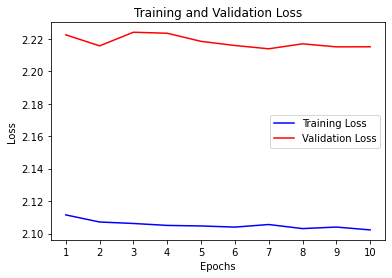

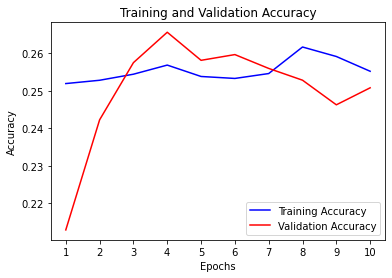

In [683]:
model=model_obj.fit_neural_network(model,X_train,y_train,X_val,y_val)

In [686]:
predict_on_pair=model_obj.prediction_test_pairs(test_df,10,12)
predict_on_pair[0]

'2858-2865'

In [687]:
test_df[test_df['L-F_Pair'].isin(predict_on_pair)]

,Local_Y,v_Class,v_Vel,v_Acc,Location,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,...,preceding_Vehicle_Velocity,preceding_Vehicle_Acceleration,preceding_Local_Y,preceding_v_Class,pair_Time_Duration,total_pair_duration,Location_cat,nextframeAcc,nextframesvel,nextframeposition
50840,10.005364,2,12.192000,0.000000,us-101,19.949160,1.636250,-0.003048,-0.073152,2858-2865,...,12.195048,0.073152,34.068714,2.0,0.000000,93.699997,1,0.000000,12.192000,11.224870
50921,11.224870,2,12.192000,0.000000,us-101,19.949160,1.636250,-0.009144,-0.054864,2858-2865,...,12.201144,0.054864,35.289135,2.0,0.100000,93.699997,1,0.000000,12.192000,12.443765
50945,12.443765,2,12.192000,0.000000,us-101,19.955256,1.636750,0.024384,0.563880,2858-2865,...,12.167616,-0.563880,36.513515,2.0,0.200000,93.699997,1,0.000000,12.192000,13.662965
51019,13.662965,2,12.192000,0.000000,us-101,19.958303,1.637000,0.149352,1.789176,2858-2865,...,12.042648,-1.789176,37.735153,2.0,0.300000,93.699997,1,0.000000,12.192000,14.882469
51173,14.882469,2,12.192000,0.000000,us-101,19.940016,1.635500,0.371856,2.843784,2858-2865,...,11.820144,-2.843784,38.937897,2.0,0.400000,93.699997,1,0.000000,12.192000,16.101364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130476,579.528442,2,15.758160,-3.413760,us-101,57.482231,3.647776,-0.646176,-2.694432,2858-2865,...,16.404337,-0.719328,641.126099,2.0,93.300003,93.699997,1,-3.151632,15.374112,581.085632
130522,581.085632,2,15.374112,-3.151632,us-101,57.543194,3.742863,-1.118616,-5.303520,2858-2865,...,16.492727,2.151888,642.744263,2.0,93.400002,93.699997,1,-0.792480,15.182088,582.592590
130541,582.592590,2,15.182088,-0.792480,us-101,57.674255,3.798836,-1.310640,-0.792480,2858-2865,...,16.492727,0.000000,644.381042,2.0,93.500000,93.699997,1,0.670560,15.148560,584.095886
130632,584.095886,2,15.148560,0.670560,us-101,57.847992,3.818712,-1.344168,0.670560,2858-2865,...,16.492727,0.000000,646.057434,2.0,93.599998,93.699997,1,0.057912,15.169896,585.616516


In [688]:
'''features:
'Rear_to_Front_Space_Headway', 
'preceding_v_Class',
"v_Class",
'Velocity Difference_Following-Preceding',
 'v_Vel',
 'Location_cat']]
predicted_data = prediction(test_df, predict_on_pair, target_variable, model,0.1)
'''
def prediction(test_df,test_range,target_variable,model,time_frame):
    predicted_df = []
    #this loop runs for each pair required predictions. 
    for current_pair in test_range:
        #Assign shape of the predictions
        input_df = []
        input_df = test_df[test_df['L-F_Pair']== current_pair]
        spacing = np.zeros(input_df.shape[0])
        local_y_subject=np.zeros(input_df.shape[0])
        local_y_preceding=np.zeros(input_df.shape[0])
        dv = np.zeros(input_df.shape[0])
        vel=np.zeros(input_df.shape[0])
        pred_acc = np.zeros(input_df.shape[0])
        
        #updating the values for first Predictions
        vel[0]=input_df.iloc[0]['v_Vel']
        spacing[0] = input_df.iloc[0]['Rear_to_Front_Space_Headway']
        dv[0] = input_df.iloc[0]['Velocity Difference_Following-Preceding']   

        pred_acc[0] = input_df.iloc[0]['v_Acc']
        local_y_subject[0]=input_df.iloc[0]['Local_Y']
        local_y_preceding[0]=input_df.iloc[0]['preceding_Local_Y']
        preceding_vehicle_class=input_df.iloc[0]['preceding_v_Class']
        vehicle_class=input_df.iloc[0]['v_Class']
        #vehicle_combination= input_df.iloc[0]['Vehicle_combination_cat']
        length_preceding_vehicle=input_df.iloc[0]['preceding_vehicle_length']
        location=input_df.iloc[0]['Location_cat']
        
        #predicting first value of acceleration
             
        predict_for_input=np.array([spacing[0],preceding_vehicle_class,vehicle_class,dv[0],vel[0],location]).reshape(1,-1)        
        pred_acc[1] = model.predict(predict_for_input)
        #calculating vel,frspacing,local.y,dv from the predicted acceleration.
        
        for j in range(1,len(input_df)):
        # v= u + at
            vel[j] = vel[j-1]+(pred_acc[j-1]*time_frame)
        
        #dv=current velocity of subject - velocity of Lead/Preceding
            dv[j] = vel[j] - input_df.iloc[j]['preceding_Vehicle_Velocity']
        
        #distance travelled by vehicle. :s 
        # s = ut + 0.5*a*t^2
            s_subject= ((vel[j-1]*time_frame) + (0.5*pred_acc[j-1]*pow(time_frame,2)))
            
            #s_lead= ((input_df.iloc[j-1]['preceding_Vehicle_Velocity']*time_frame) + (0.5*input_df.iloc[j-1]['preceding_Vehicle_Acceleration']*pow(time_frame,2)))
            
            local_y_subject[j]=  local_y_subject[j-1] + s_subject
            #spacing[j] = spacing[j-1]+ s_lead- s_subject
            local_y_preceding[j]=  input_df.iloc[j-1]['preceding_Local_Y']
            spacing[j]=local_y_preceding[j] - local_y_subject[j] - input_df.iloc[j-1]['preceding_Local_Y'] -length_preceding_vehicle
            print(f"s_subject: {s_subject},local_y_subject:{local_y_subject[j]},local_y_preceding: {local_y_preceding[j]},spacing[j]:{spacing[j]}")
            if j == len(input_df)-1: # as we are predicting the next values, we should not predict for the last one. 
                break
            #if j == 5: # this is temporary
            #    break
            
            predict_for_input=np.array([spacing[j],preceding_vehicle_class,vehicle_class,dv[j],vel[j],location]).reshape(1,-1)
            #pred_acc[j+1] = model.predict(np.array([spacing[j],vehicle_combination,local_y[j],dv[j],vel[j]])) 
            pred_acc[j+1] = model.predict(predict_for_input) 
            print(f"j: {j},predict_for_input:{predict_for_input},pred_acc: {pred_acc[j+1]}")

             ########
             #print(pred_acc)
             ########
        
        print(f"input_df shape: {input_df.shape}")
        print(f"pred_acc shape: {pred_acc.shape}")
        input_df['predicted_acceleration']=pred_acc
        input_df['predicted_velocity']=vel

        predicted_df.append(input_df)
        result = pd.concat(predicted_df)
    return result

In [689]:
target_variable = 'nextframeAcc'

predicted_data = prediction(test_df, predict_on_pair, target_variable, model,0.1)

s_subject: 1.2192000389099122,local_y_subject:11.224564456939698,local_y_preceding: 34.0687141418457,spacing[j]:-15.339364433288573
j: 1,predict_for_input:[[-1.53393644e+01  2.00000000e+00  2.00000000e+00 -9.14382935e-03
   1.21920004e+01  1.00000000e+00]],pred_acc: 0.00043395161628723145
s_subject: 1.2195241115987303,local_y_subject:12.444088568538428,local_y_preceding: 35.28913497924805,spacing[j]:-16.558888544887303
j: 2,predict_for_input:[[-16.55888854   2.           2.           0.03086595  12.19848184
    1.        ]],pred_acc: 0.00043392181396484375
s_subject: 1.2198503540456296,local_y_subject:13.663938922584057,local_y_preceding: 36.51351547241211,spacing[j]:-17.778738898932936
j: 3,predict_for_input:[[-17.7787389    2.           2.           0.15587692  12.19852524
    1.        ]],pred_acc: 0.00043383240699768066
s_subject: 1.2198546934127807,local_y_subject:14.883793615996838,local_y_preceding: 37.73515319824219,spacing[j]:-18.998593592345713
j: 4,predict_for_input:[[-18.99

In [690]:
predicted_data

,Local_Y,v_Class,v_Vel,v_Acc,Location,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,...,preceding_Local_Y,preceding_v_Class,pair_Time_Duration,total_pair_duration,Location_cat,nextframeAcc,nextframesvel,nextframeposition,predicted_acceleration,predicted_velocity
50840,10.005364,2,12.192000,0.000000,us-101,19.949160,1.636250,-0.003048,-0.073152,2858-2865,...,34.068714,2.0,0.000000,93.699997,1,0.000000,12.192000,11.224870,0.000000,12.192000
50921,11.224870,2,12.192000,0.000000,us-101,19.949160,1.636250,-0.009144,-0.054864,2858-2865,...,35.289135,2.0,0.100000,93.699997,1,0.000000,12.192000,12.443765,0.064815,12.192000
50945,12.443765,2,12.192000,0.000000,us-101,19.955256,1.636750,0.024384,0.563880,2858-2865,...,36.513515,2.0,0.200000,93.699997,1,0.000000,12.192000,13.662965,0.000434,12.198482
51019,13.662965,2,12.192000,0.000000,us-101,19.958303,1.637000,0.149352,1.789176,2858-2865,...,37.735153,2.0,0.300000,93.699997,1,0.000000,12.192000,14.882469,0.000434,12.198525
51173,14.882469,2,12.192000,0.000000,us-101,19.940016,1.635500,0.371856,2.843784,2858-2865,...,38.937897,2.0,0.400000,93.699997,1,0.000000,12.192000,16.101364,0.000434,12.198569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116346,595.001282,2,15.243048,-0.060960,us-101,41.434513,2.718256,-2.328672,-1.490472,2832-2838,...,641.006897,2.0,71.000000,71.400002,1,0.000000,15.240000,596.524719,0.195846,15.917323
116409,596.524719,2,15.240000,0.000000,us-101,41.675304,2.734600,-2.502408,-1.527048,2832-2838,...,642.771667,2.0,71.099998,71.400002,1,0.646176,15.282672,598.044739,0.202800,15.936908
116454,598.044739,2,15.282672,0.646176,us-101,41.910000,2.742321,-2.459736,0.646176,2832-2838,...,644.526123,2.0,71.199997,71.400002,1,0.054864,15.300960,599.580627,0.203667,15.957188
116516,599.580627,2,15.300960,0.054864,us-101,42.202606,2.758167,-2.441448,0.054864,2832-2838,...,646.354614,2.0,71.300003,71.400002,1,-0.615696,15.261336,601.113159,0.203560,15.977554


In [691]:
prediction1 = predicted_data[predicted_data["L-F_Pair"]== predict_on_pair[0]]
prediction1

,Local_Y,v_Class,v_Vel,v_Acc,Location,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,...,preceding_Local_Y,preceding_v_Class,pair_Time_Duration,total_pair_duration,Location_cat,nextframeAcc,nextframesvel,nextframeposition,predicted_acceleration,predicted_velocity
50840,10.005364,2,12.192000,0.000000,us-101,19.949160,1.636250,-0.003048,-0.073152,2858-2865,...,34.068714,2.0,0.000000,93.699997,1,0.000000,12.192000,11.224870,0.000000,12.192000
50921,11.224870,2,12.192000,0.000000,us-101,19.949160,1.636250,-0.009144,-0.054864,2858-2865,...,35.289135,2.0,0.100000,93.699997,1,0.000000,12.192000,12.443765,0.064815,12.192000
50945,12.443765,2,12.192000,0.000000,us-101,19.955256,1.636750,0.024384,0.563880,2858-2865,...,36.513515,2.0,0.200000,93.699997,1,0.000000,12.192000,13.662965,0.000434,12.198482
51019,13.662965,2,12.192000,0.000000,us-101,19.958303,1.637000,0.149352,1.789176,2858-2865,...,37.735153,2.0,0.300000,93.699997,1,0.000000,12.192000,14.882469,0.000434,12.198525
51173,14.882469,2,12.192000,0.000000,us-101,19.940016,1.635500,0.371856,2.843784,2858-2865,...,38.937897,2.0,0.400000,93.699997,1,0.000000,12.192000,16.101364,0.000434,12.198569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130476,579.528442,2,15.758160,-3.413760,us-101,57.482231,3.647776,-0.646176,-2.694432,2858-2865,...,641.126099,2.0,93.300003,93.699997,1,-3.151632,15.374112,581.085632,0.203525,14.793066
130522,581.085632,2,15.374112,-3.151632,us-101,57.543194,3.742863,-1.118616,-5.303520,2858-2865,...,642.744263,2.0,93.400002,93.699997,1,-0.792480,15.182088,582.592590,0.202947,14.813419
130541,582.592590,2,15.182088,-0.792480,us-101,57.674255,3.798836,-1.310640,-0.792480,2858-2865,...,644.381042,2.0,93.500000,93.699997,1,0.670560,15.148560,584.095886,0.203452,14.833713
130632,584.095886,2,15.148560,0.670560,us-101,57.847992,3.818712,-1.344168,0.670560,2858-2865,...,646.057434,2.0,93.599998,93.699997,1,0.057912,15.169896,585.616516,0.203353,14.854059


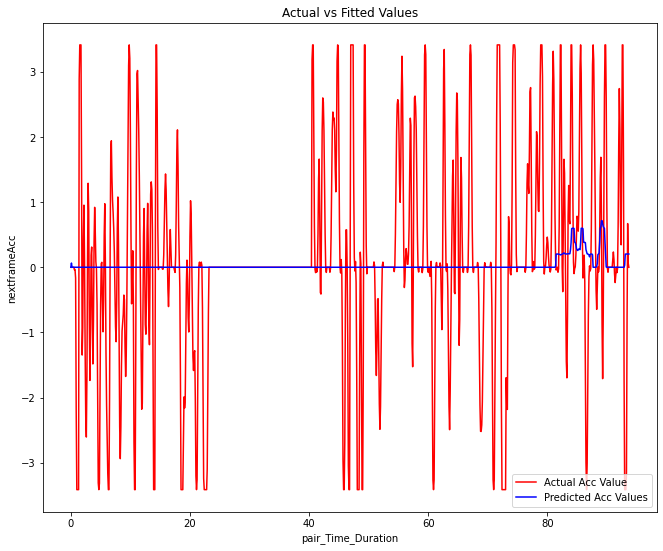

In [692]:
plt.figure(figsize=(11, 9))


ax = sns.lineplot(x=prediction1["pair_Time_Duration"], y = prediction1["nextframeAcc"], color="r", label="Actual Acc Value")
sns.lineplot(x=prediction1["pair_Time_Duration"], y =prediction1["predicted_acceleration"],  color="b", label="Predicted Acc Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()



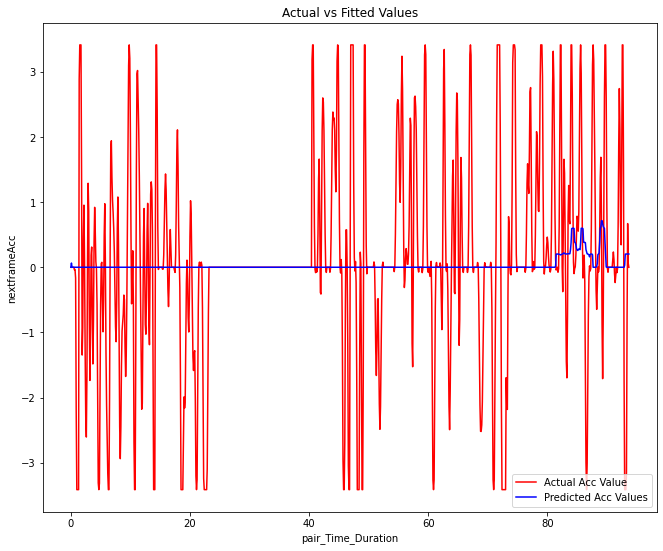

In [693]:
plt.figure(figsize=(11, 9))


ax = sns.lineplot(x=prediction1["pair_Time_Duration"], y = prediction1["nextframeAcc"], color="r", label="Actual Acc Value")
sns.lineplot(x=prediction1["pair_Time_Duration"], y =prediction1["predicted_acceleration"],  color="b", label="Predicted Acc Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [694]:
ngsim.columns

Index(['Local_Y', 'v_Class', 'v_Vel', 'v_Acc', 'Location',
       'Rear_to_Front_Space_Headway', 'Front_To_Rear_Time_Headway',
       'Velocity Difference_Following-Preceding',
       'Acceleration Difference_Following-Preceding', 'L-F_Pair',
       'preceding_vehicle_length', 'preceding_Vehicle_Velocity',
       'preceding_Vehicle_Acceleration', 'preceding_Local_Y',
       'preceding_v_Class', 'pair_Time_Duration', 'total_pair_duration',
       'Location_cat', 'nextframeAcc', 'nextframesvel', 'nextframeposition'],
      dtype='object')